# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Musthafa 'Abduh Fakhruddin
- **Email:** abduhmusthafa@gmail.com
- **ID Dicoding:** maf_valiant

# Import Semua Packages/Library yang Digunakan

In [1]:
import os
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Data Preparation

## Data Loading

In [2]:
folders = {
    'train_dog': '../input/animal-faces/afhq/train/dog/*.jpg',
    'train_cat': '../input/animal-faces/afhq/train/cat/*.jpg',
    'train_wild': '../input/animal-faces/afhq/train/wild/*.jpg',
    'test_dog': '../input/animal-faces/afhq/val/dog/*.jpg',
    'test_cat': '../input/animal-faces/afhq/val/cat/*.jpg',
    'test_wild': '../input/animal-faces/afhq/val/wild/*.jpg'
}

In [3]:
# Kategori yang ingin kita buat ulang
categories = ['dog', 'cat', 'wild']

# List untuk menyimpan data
data = []

# Loop melalui setiap kategori dan tambahkan file path serta labelnya
for category in categories:
    train_files = glob(folders[f'train_{category}'])
    test_files = glob(folders[f'test_{category}'])
    
    # Gabungkan semua file dengan label kategori
    data.extend([(file, category) for file in train_files + test_files])

# Buat DataFrame dari data yang telah dikumpulkan
df = pd.DataFrame(data, columns=['file_path', 'category'])

In [4]:
df.head(5)

,file_path,category
0,../input/animal-faces/afhq/train/dog/pixabay_d...,dog
1,../input/animal-faces/afhq/train/dog/pixabay_d...,dog
2,../input/animal-faces/afhq/train/dog/flickr_do...,dog
3,../input/animal-faces/afhq/train/dog/flickr_do...,dog
4,../input/animal-faces/afhq/train/dog/flickr_do...,dog


In [5]:
print(df['category'].value_counts())

category
cat     5653
dog     5239
wild    5238
Name: count, dtype: int64


## Data Preprocessing

In [6]:
# Fungsi untuk membaca dan meresize gambar menggunakan TensorFlow
def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)  # Membaca gambar dari file path
    img = tf.image.decode_jpeg(img, channels=3)  # Decode JPG menjadi tensor RGB
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])  # Resize gambar ke ukuran tetap
    img = img / 255.0  # Normalisasi pixel (0-1)
    return img

In [7]:
# Load semua gambar dan kategorinya
IMG_SIZE = 64
TARGET_SIZE = 6000  # Jumlah target gambar per kategori


In [8]:
X = np.array([load_and_preprocess_image(file_path).numpy() for file_path in df['file_path']], dtype="float32")

# Konversi label kategori ke angka
label_mapping = {'dog': 0, 'cat': 1, 'wild': 2}
y = np.array([label_mapping[label] for label in df['category']])

# Konversi label ke one-hot encoding untuk model deep learning
y = to_categorical(y, num_classes=3)

# Split data menjadi train dan test set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Cek hasil preprocessing
print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (12904, 64, 64, 3)
Shape y_train: (12904, 3)
Shape X_test: (3226, 64, 64, 3)
Shape y_test: (3226, 3)


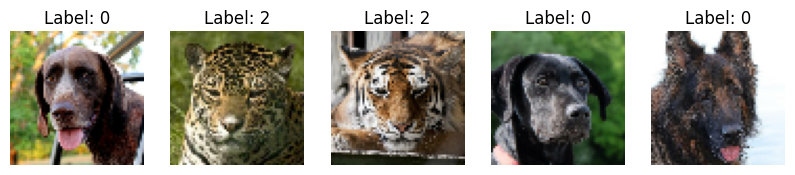

In [9]:
# Tampilkan 5 gambar pertama
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis("off")

plt.show()

In [10]:
# Augmentasi dengan ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,      # Rotasi acak hingga 20 derajat
    width_shift_range=0.2,  # Geser lebar hingga 20%
    height_shift_range=0.2, # Geser tinggi hingga 20%
    shear_range=0.2,        # Distorsi perspektif
    zoom_range=0.2,         # Zoom hingga 20%
    horizontal_flip=True,   # Flip horizontal
    fill_mode='nearest'     # Isi piksel yang hilang
)

In [11]:
# Fungsi untuk menambah data hingga mencapai jumlah yang diinginkan
def augment_data(X_train, y_train, target_size):
    X_augmented, y_augmented = [], []
    
    # Hitung jumlah gambar per kategori
    class_counts = np.sum(y_train, axis=0)
    
    for class_idx in range(len(class_counts)):  # Untuk setiap kategori
        current_count = int(class_counts[class_idx])  # Jumlah saat ini
        if current_count >= target_size:
            continue  # Jika sudah cukup, lanjut ke kategori berikutnya
        
        # Filter gambar dengan kategori ini
        mask = np.argmax(y_train, axis=1) == class_idx
        X_class, y_class = X_train[mask], y_train[mask]
        
        # Augmentasi hingga mencapai target
        while current_count < target_size:
            for X_batch, y_batch in datagen.flow(X_class, y_class, batch_size=32):
                X_augmented.append(X_batch)
                y_augmented.append(y_batch)
                current_count += len(X_batch)
                if current_count >= target_size:
                    break
    
    # Gabungkan dengan data asli
    X_train = np.concatenate([X_train] + X_augmented, axis=0)
    y_train = np.concatenate([y_train] + y_augmented, axis=0)
    
    return X_train, y_train

In [12]:
# Perbanyak dataset hingga tiap kategori mencapai 6000
X_train, y_train = augment_data(X_train, y_train, TARGET_SIZE)

# Cek hasil akhir
print("Shape X_train setelah augmentasi:", X_train.shape)
print("Shape y_train setelah augmentasi:", y_train.shape)

Shape X_train setelah augmentasi: (18056, 64, 64, 3)
Shape y_train setelah augmentasi: (18056, 3)


# TRAINING DAN MODELING

In [13]:
# Arsitektur CNN dengan Dropout
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout untuk mencegah overfitting
    Dense(3, activation='softmax')  # 3 kelas: Dog, Cat, Wild
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

In [15]:
# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Training model dengan callbacks
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=32,
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.5999 - loss: 0.7909 - val_accuracy: 0.9374 - val_loss: 0.1832 - learning_rate: 0.0010
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8827 - loss: 0.3027 - val_accuracy: 0.9563 - val_loss: 0.1251 - learning_rate: 0.0010
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9200 - loss: 0.2173 - val_accuracy: 0.9659 - val_loss: 0.0978 - learning_rate: 0.0010
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9420 - loss: 0.1618 - val_accuracy: 0.9609 - val_loss: 0.1287 - learning_rate: 0.0010
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9534 - loss: 0.1208 - val_accuracy: 0.9678 - val_loss: 0.0995 - learning_rate: 0.0010
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9670 - loss: 0.0914 - val_accuracy: 0.9696 - val_loss: 0.1055 - learning_rate: 0.0010
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9826 - loss: 0.0507 

In [17]:
# Evaluasi model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc:.4f}')

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9646 - loss: 0.0890

Test accuracy: 0.9659


# PLOT AKURASI DAN LOSS

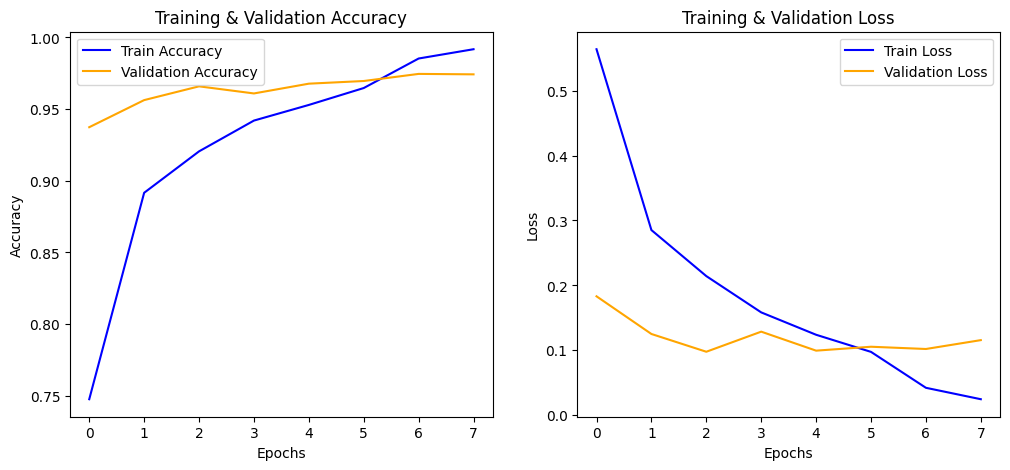

In [18]:
# Fungsi untuk plotting akurasi dan loss
def plot_history(history):
    plt.figure(figsize=(12,5))

    # Plot Akurasi
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training & Validation Accuracy")

    # Plot Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")

    plt.show()

# Panggil fungsi untuk menampilkan plot
plot_history(history)

# SAVE DAN KONVERSI MODEL

## keras

In [19]:
model.save("animal_classifier.keras")

## saved_model

In [20]:
model.export("saved_model")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139276397513184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276397526384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276397515296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276398039056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276398039232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276398035536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276398036768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276398039584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276398040816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276398041168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276398041696: Tens

## Konversi ke TF-Lite

In [21]:
saved_model_dir = "/kaggle/working/saved_model"

In [22]:
# Konversi ke TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Simpan model ke file .tflite
tflite_model_path = "/kaggle/working/model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"✅ Model berhasil dikonversi dan disimpan di {tflite_model_path}")

✅ Model berhasil dikonversi dan disimpan di /kaggle/working/model.tflite


## Konversi ke TensorFlow.js (TFJS)

In [23]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.6 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq

In [24]:
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

2025-02-16 05:34:05.457943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-16 05:34:05.478592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-16 05:34:05.484646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1739684050.957597     315 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739684050.958088     315 cuda_executor.cc:1015] succ

# Export

In [25]:
import zipfile

zip_filename = "/kaggle/working/model.zip"

In [26]:
labels = ["dog", "cat", "wild"]  # Sesuaikan dengan kelas modelmu

# Simpan ke file
with open("/kaggle/working/labels.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

print("✅ labels.txt berhasil dibuat!")

✅ labels.txt berhasil dibuat!


In [27]:
# List file yang ingin disimpan
files_to_save = [
    "/kaggle/working/model.tflite",
    "/kaggle/working/labels.txt",
    
    "/kaggle/working/saved_model/saved_model.pb",
    "/kaggle/working/saved_model/fingerprint.pb",

]

folders_to_save = [
    "/kaggle/working/tfjs_model",
    "/kaggle/working/saved_model/variables",
]

In [28]:
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Tambahkan file satu per satu
    for file in files_to_save:
        zipf.write(file, os.path.basename(file))  # Simpan tanpa path asli
    
    # Tambahkan folder & isinya
    for folder in folders_to_save:
        for root, _, files in os.walk(folder):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, "/kaggle/working")  # Simpan dengan struktur relatif
                zipf.write(file_path, arcname)

print(" model.zip sekarang berisi semua file & folder!")

 model.zip sekarang berisi semua file & folder!


In [29]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
